# Objective:

This is a first attempt at creating a simple GAN model following the documentation of *Deep Learning with Pytorch* by Vishnu Subramanian and this Medium article: https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f

Certain model parameters and structure will be based off of the pix2pix model implemented in *Image-to-Image Translation with Conditional Adversarial Networks* by Isola, et al.  


In [234]:
import pandas as pd 
import numpy as np

from pathlib import Path
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import itertools
import time 
import cv2
import os

from PIL import Image
import math

## 1. Load re-sized images and their corresponding sketches 

In [235]:
!pwd

/home/ec2-user/couch_gan


In [236]:
## code to resize images 

# def resize_(path, sz=250):
#     """
#     resizes a image based on a center crop and to scale horizontal and vertical axis to a size 
#     """
#     im = cv2.imread(str(path))
#     return cv2.resize(im, (sz, sz))   

# def resize_all_images(orig_path, new_path):
#     """
#     resizes an entire directory and saves to a new directory 
#     """
#     for f in (orig_path).iterdir():  # iterating through a directory 
#         img = resize_(f)  # crop each file 
#         path = new_path/f.name # saves file path 
#         cv2.imwrite(str(path), img)  # writes out image to the file path 
        
# os.makedirs("./data/resized_250/original", exist_ok=True)
# os.makedirs("./data/resized_250/sketch", exist_ok=True)

# resize_all_images(orig_path=Path('./data/og_resized'), new_path=Path('./data/resized_250/original'))
# resize_all_images(orig_path=Path('./data/sketch_resized/'), new_path=Path('./data/resized_250/sketch'))

In [237]:
# assign paths 
# real_img_path = Path('./data/og_resized')
# sketch_img_path = Path('./data/sketch_resized')
real_img_path = Path('./data/resized_250/original/')
sketch_img_path = Path('./data/resized_250/sketch/')
fake_img_path = Path('./data/fake')

In [238]:
# get files into list  
real_img_files = [f for f in real_img_path.iterdir()]
sketch_img_files = [f for f in sketch_img_path.iterdir()]

## 2. Get image names of training and test files (assigned by Kaggle)

In [239]:
test_file_names = [f'00000{i}.jpg' for i in range(203, 303)]

In [240]:
# assign paths to appropriate lists 
train_real_paths = []
train_sketch_paths = []
test_real_paths = []
test_sketch_paths = []

for f in real_img_files:
    if f.parts[-1] in test_file_names:
        test_real_paths.append(f)
    else:
        train_real_paths.append(f)

for f in sketch_img_files:
    if f.parts[-1] in test_file_names:
        test_sketch_paths.append(f)
    else:
        train_sketch_paths.append(f)        

In [241]:
# remove any inapporpiate files like .DS_Store 
train_sketch_paths = [file for file in train_sketch_paths if not file.parts[-1].startswith('.')]
test_real_paths = [file for file in test_real_paths if not file.parts[-1].startswith('.')]
test_sketch_paths = [file for file in test_sketch_paths if not file.parts[-1].startswith('.')]
train_real_paths = [file for file in train_real_paths if not file.parts[-1].startswith('.')]


In [242]:
# sanity check that the order of real and sketch paths are the same 
counter = 0
for r, f in zip(train_real_paths, train_sketch_paths):
    if r.parts[-1] == r.parts[-1]:
        counter += 1
assert(counter == 900)

counter = 0
for r, f in zip(test_real_paths, test_sketch_paths):
    if r.parts[-1] == r.parts[-1]:
        counter += 1
assert(counter == 100)

## 3. Couch Dataset  and Dataloaders 

Note: No data augmentation 

In [243]:
def getX(path):
    x = cv2.imread(str(path)).astype(np.float32)  # reading image 
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255  # convert from BGR to RGB
    return x 

In [244]:
def normalize(im):
    """Normalizes images """
    imagenet_stats = np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [245]:
class CouchDataset(Dataset):
    def __init__(self, real_files, sketch_files):
        self.real_files = real_files
        self.sketch_files = sketch_files
        
    def __len__(self):
        return len(self.real_files)  # should be same number as sketch files 
        
    def __getitem__(self, idx):
        real_path = self.real_files[idx]
        sketch_path = self.sketch_files[idx]
        img_name = sketch_path.parts[-1]
        
        x_real = getX(real_path)
        x_sketch = getX(sketch_path)
        
        # normalize 
        x_real = normalize(x_real)
        x_sketch = normalize(x_sketch)
        
        # roll axis (channels, height, width)
        x_real = np.rollaxis(x_real, 2)
        x_sketch = np.rollaxis(x_sketch, 2)
        
        return x_sketch, x_real
        

In [246]:
# make datasets 
train_couch_ds = CouchDataset(real_files=train_real_paths, sketch_files=train_sketch_paths)
test_couch_ds = CouchDataset(real_files=test_real_paths, sketch_files=test_sketch_paths)



In [247]:
# inspect content 
x_s, x_r = train_couch_ds[20]


In [248]:
x_s, x_r

(array([[[ 1.        ,  1.        ,  1.        , ...,  0.97647059,
           1.        ,  0.97647059],
         [ 1.        ,  1.        ,  1.        , ..., -0.84313725,
          -0.89019608,  0.42745101],
         [ 1.        ,  1.        ,  1.        , ...,  0.78039217,
           0.78039217,  0.94509804],
         ...,
         [ 1.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  1.        ]],
 
        [[ 1.        ,  1.        ,  1.        , ...,  0.97647059,
           1.        ,  0.97647059],
         [ 1.        ,  1.        ,  1.        , ..., -0.84313725,
          -0.89019608,  0.42745101],
         [ 1.        ,  1.        ,  1.        , ...,  0.78039217,
           0.78039217,  0.94509804],
         ...,
         [ 1.        ,  1.       

In [249]:
x_s.shape, x_r.shape

((3, 250, 250), (3, 250, 250))

## 4. Model  

In [250]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch

from torchvision.models import resnet18

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

In [251]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [252]:
# # based on Pix2pix GAN 
# ## https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/pix2pix/models.py

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1, bias=False)]
#         layers = [nn.Conv2d(in_size, out_size, kernel_size=3, padding=1, bias=False)] # using https://github.com/xiaopeng-liao/Pytorch-UNet/blob/master/unet/unet_parts.py

        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
#         print("original x shape", x.shape)
        
        # pad so that the matrices concatenate 
        diffX = skip_input.size()[2] - x.size()[2]
        diffY = skip_input.size()[3] - x.size()[3]
        x1 = F.pad(x, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
#         print("x1 shape", x.shape)
        
        x = torch.cat((x1, skip_input), 1)
#         print("concatenated x shape", x.shape)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, out_channels, 3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
#         print("x", x.shape)
#         print("d1",d1.shape)
#         print("d2",d2.shape)
#         print("d3",d3.shape)
#         print("d4",d4.shape)
#         print("d5",d5.shape)
#         print("d6",d6.shape)
#         print("d7",d7.shape)
#         print("d8",d8.shape)
        
        u1 = self.up1(d8, d7)
#         print("u1", u1.shape)
        u2 = self.up2(u1, d6)
#         print("u2", u2.shape)
        u3 = self.up3(u2, d5)
#         print("u3", u3.shape)

        u4 = self.up4(u3, d4)
#         print("u4", u4.shape)

        u5 = self.up5(u4, d3)
#         print("u5", u5.shape)

        u6 = self.up6(u5, d2)
#         print("u6", u6.shape)

        u7 = self.up7(u6, d1)
#         print("u7", u7.shape)

        return self.final(u7)




In [253]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 3, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        final = F.adaptive_avg_pool2d(self.model(img_input), 1)
#         print("final", final)
        return final

In [254]:
# class Discriminator(nn.Module):
    
#     def __init__(self, nc=3, n_classes=1, **kwargs):
#         super(Discriminator, self).__init__()
#         self.conv1 = nn.Conv2d(nc, 96, 3, padding=1)
#         self.conv2 = nn.Conv2d(96, 96, 3, padding=1)
#         self.conv3 = nn.Conv2d(96, 96, 3, padding=1, stride=2)
#         self.conv4 = nn.Conv2d(96, 192, 3, padding=1)
#         self.conv5 = nn.Conv2d(192, 192, 3, padding=1)
#         self.conv6 = nn.Conv2d(192, 192, 3, padding=1, stride=2)
#         self.conv7 = nn.Conv2d(192, 192, 3, padding=1)
#         self.conv8 = nn.Conv2d(192, 192, 1)

#         self.bn1 = nn.BatchNorm2d(96)
#         self.bn2 = nn.BatchNorm2d(96)
#         self.bn3 = nn.BatchNorm2d(96)
#         self.bn4 = nn.BatchNorm2d(192)
#         self.bn5 = nn.BatchNorm2d(192)
#         self.bn6 = nn.BatchNorm2d(192)
#         self.bn7 = nn.BatchNorm2d(192)
#         self.bn8 = nn.BatchNorm2d(192)
#         self.bn9 = nn.BatchNorm2d(n_classes)
        
#         self.class_conv = nn.Conv2d(192, n_classes, 1)

#     def forward(self, img_A, img_B):
#         # concatenate images by channels 
#         x = torch.cat((img_A, img_B), 1)
        
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.relu(self.bn3(self.conv3(x)))
#         x = F.relu(self.bn4(self.conv4(x)))
#         x = F.relu(self.bn5(self.conv5(x)))
#         x = F.relu(self.bn6(self.conv6(x)))
#         x = F.relu(self.bn7(self.conv7(x)))
#         x = F.relu(self.bn8(self.conv8(x)))

#         class_out = F.relu(self.bn9(self.class_conv(x)))
#         pool_out = F.adaptive_avg_pool2d(class_out, 1)
#         pool_out.squeeze_(-1)
#         pool_out.squeeze_(-1)
#         return pool_out

## 5. Training 

In [255]:
# Create sample and checkpoint directories
os.makedirs("checkpoint", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)
os.makedirs("fake_imgs", exist_ok=True)


#### Debugging 

In [256]:
# create small data loaders 
# batch_size = 10
batch_size = 4
train_dl = DataLoader(train_couch_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_couch_ds, batch_size=batch_size)

In [257]:
train_x_s, train_x_r = next(iter(train_dl))

In [258]:
train_x_s.shape

torch.Size([4, 3, 250, 250])

In [259]:
train_x_r.shape

torch.Size([4, 3, 250, 250])

In [260]:
input_shape = (3, 250, 250)  # TODO: dynamically grab this 

# used default parameters for this 
latent_dim = 8 
lr = 0.01
b1 = 0.5  # adam: decay of first order momentum of gradient
b2 = 0.999  # adam: decay of first order momentum of gradient


In [261]:
# Loss weight of L1 pixel-wise loss between translated image and real image
# lambda_pixel = 100
lambda_pixel = 5

In [262]:
# Calculate output of image discriminator (PatchGAN)
img_height = 250
img_width = 250

In [263]:
# Initialize generator and discriminator and loss functions 
generator = GeneratorUNet().cuda()
discriminator = Discriminator().cuda()
criterion_GAN = torch.nn.MSELoss().cuda()
criterion_pixelwise = torch.nn.L1Loss().cuda()

In [264]:
# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [265]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))


In [266]:
# Tensor type
Tensor = torch.cuda.FloatTensor 

In [267]:
def sample_images(batches_done):
    """Saves a generated sample from the validation set"""
    x_sketch, x_real = next(iter(test_dl))
    
    x_sketch_var = Variable(x_sketch.type(Tensor))
    x_real_var = Variable(x_real.type(Tensor))
    fake_from_sketch = generator(x_sketch_var)
    
    img_sample = torch.cat((x_sketch_var.data, fake_from_sketch.data, x_real_var.data), -2)
    save_image(img_sample, "fake_imgs/%s/%s.png" % ("pix2pix", batches_done), nrow=5, normalize=True)
    

In [272]:
for epoch in range(5):
    sum_G_loss = 0
    sum_D_loss = 0
    total = 0

    for sketch, real in train_dl:
        sketch = sketch.cuda().float()
        real = real.cuda().float()
        batch_size = sketch.shape[0]
        total += batch_size

        valid = Tensor(np.ones(batch_size))
        fake = Tensor(np.zeros(batch_size))

        # ---------------------
        #  Train Generator 
        # ---------------------
        optimizer_G.zero_grad()

        fake_sketch = generator(sketch)
        pred_fake = discriminator(fake_sketch, sketch)
        loss_GAN = criterion_GAN(pred_fake, valid)

        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_sketch, real)

        # total loss 
        # print("loss_GAN", loss_GAN)
        # print("loss_pixel", loss_pixel)
        loss_G = loss_GAN + lambda_pixel * loss_pixel
    #     print("Loss G", loss_G)

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator  
        # --------------------- 
        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real, sketch)
        loss_real = criterion_GAN(pred_real, valid)
    #     print("loss_real", loss_real)

        # Fake loss
        pred_fake = discriminator(fake_sketch.detach(), sketch)
        loss_fake = criterion_GAN(pred_fake, fake)
    #     print("loss_fake", loss_fake)

        loss_D = 0.5 * (loss_real + loss_fake)
#         print("loss_D", loss_D)

        loss_D.backward()
        optimizer_D.step()
        sum_G_loss+= loss_G
        sum_D_loss+= loss_D
        
avg_G_loss = sum_G_loss/total
avg_D_loss = sum_D_loss/total


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sketch Image


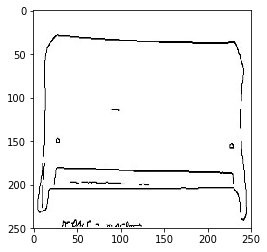

Generated Image


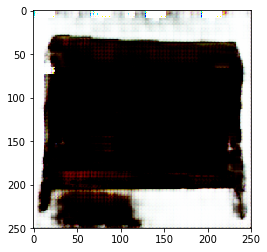

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real Image


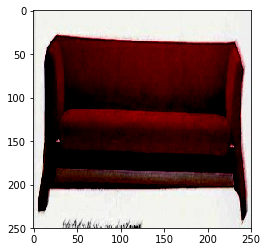

In [276]:
for sketch, real_img in test_dl:
    sketch = sketch.cuda().float()
    real_img = real_img.cuda().float()
    gen_img = generator(sketch)
    gen_img = gen_img.view(sketch.shape)

idx = 1 # pick any number between [0,bs]

print('Sketch Image')
plt.imshow(np.rollaxis(np.rollaxis(sketch[idx].cpu().detach().numpy(), 2),2))
plt.show()

print('Generated Image')
plt.imshow(np.rollaxis(np.rollaxis(F.relu(gen_img[idx]).cpu().detach().numpy(), 2),2))
plt.show()

print('Real Image')
plt.imshow(np.rollaxis(np.rollaxis(real_img[idx].cpu().detach().numpy(), 2),2))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
Sketch Image


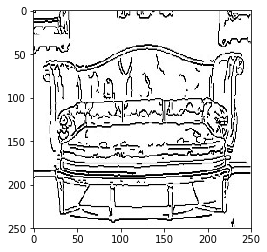

Generated Image


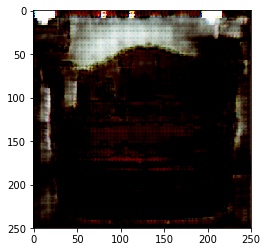

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real Image


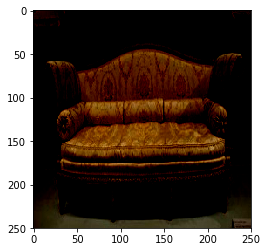

In [282]:
idx = np.random.choice(range(batch_size))# pick any number between [0,bs]
print(idx)

print('Sketch Image')
plt.imshow(np.rollaxis(np.rollaxis(sketch[idx].cpu().detach().numpy(), 2),2))
plt.show()

print('Generated Image')
plt.imshow(np.rollaxis(np.rollaxis(F.relu(gen_img[idx]).cpu().detach().numpy(), 2),2))
plt.show()

print('Real Image')
plt.imshow(np.rollaxis(np.rollaxis(real_img[idx].cpu().detach().numpy(), 2),2))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
Sketch Image


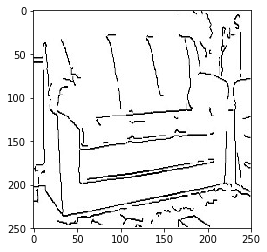

Generated Image


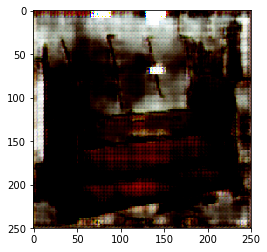

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real Image


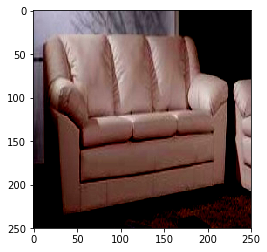

In [283]:
idx = np.random.choice(range(batch_size))# pick any number between [0,bs]
print(idx)

print('Sketch Image')
plt.imshow(np.rollaxis(np.rollaxis(sketch[idx].cpu().detach().numpy(), 2),2))
plt.show()

print('Generated Image')
plt.imshow(np.rollaxis(np.rollaxis(F.relu(gen_img[idx]).cpu().detach().numpy(), 2),2))
plt.show()

print('Real Image')
plt.imshow(np.rollaxis(np.rollaxis(real_img[idx].cpu().detach().numpy(), 2),2))
plt.show()